## Определение перспективного тарифа для телеком компании

### Описание проекта

### Описание данных

* Таблица users (информация о пользователях):
    - user_id — уникальный идентификатор пользователя
    - first_name — имя пользователя
    - last_name — фамилия пользователя
    - age — возраст пользователя (годы)
    - reg_date — дата подключения тарифа (день, месяц, год)
    - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    - city — город проживания пользователя
    - tariff — название тарифного плана
* Таблица calls (информация о звонках):
    - id — уникальный номер звонка
    - call_date — дата звонка
    - duration — длительность звонка в минутах
    - user_id — идентификатор пользователя, сделавшего звонок
* Таблица messages (информация о сообщениях):
    - id — уникальный номер сообщения
    - message_date — дата сообщения
    - user_id — идентификатор пользователя, отправившего сообщение
* Таблица internet (информация об интернет-сессиях):
    - id — уникальный номер сессии
    - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    - session_date — дата интернет-сессии
    - user_id — идентификатор пользователя
* Таблица tariffs (информация о тарифах):
    - tariff_name — название тарифа
    - rub_monthly_fee — ежемесячная абонентская плата в рублях
    - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    - messages_included — количество сообщений в месяц, включённых в абонентскую плату
    - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

---

##### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

In [2]:
df_calls=pd.read_csv('/datasets/calls.csv')
df_internet=pd.read_csv('/datasets/internet.csv')
df_messages=pd.read_csv('/datasets/messages.csv')
df_tariffs=pd.read_csv('/datasets/tariffs.csv')
df_users=pd.read_csv('/datasets/users.csv')

In [3]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [5]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [6]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [7]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


##### Шаг 2. Подготовьте данные

Объединим таблицы 'df_calls','df_internet','df_messages' с 'df_users'. Для этого подготовим столбцы, чтобы далее проще было группировать, и создадим в каждой таблице столбец с датой и месяцем.

In [8]:
df_list=[df_calls,df_internet,df_messages]
date_list=['call_date','session_date','message_date']
for df,date in zip(df_list,date_list):
    df['date']=pd.to_datetime(df[date], format='%Y-%m-%d' )
    df['month']=pd.DatetimeIndex(df[date]).month
    

Сгруппируем таблицы под 'user_id' и 'month' и оставим в качестве индекса только 'user_id'.

In [9]:
df_calls_gr=df_calls.groupby(['user_id','month'])['duration'].sum().reset_index(level='month')
df_internet_gr=df_internet.groupby(['user_id','month'])['mb_used'].sum().reset_index(level='month')
df_messages_gr=df_messages.groupby(['user_id','month'])['message_date'].count()


Переименуем столбцы, чтобы после объединения можно было различать данные и не возвращаться с данной задаче

In [10]:
df_calls_gr.columns=['month','calls_duration']
df_internet_gr.columns=['month','internet_mb_used']
df_messages_gr.name='messages'

По очереди объединим таблицы 'df_calls_gr','df_internet_gr','df_messages_gr' c 'df_users'. Воспользуемся функцией how='outer', чтобы не потерять данные.

In [11]:
df_users_total=df_users.merge(df_calls_gr,on='user_id',how='outer')


Будем объединять по двум столбцам 'user_id' , 'month'

In [12]:
df_users_total=df_users_total.merge(df_internet_gr,on=('user_id','month'),how='outer')


In [13]:
df_users_total=df_users_total.merge(df_messages_gr,on=('user_id','month'),how='outer')


In [14]:
df_users_total

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_duration,internet_mb_used,messages
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,150.06,2253.49,22.0
1,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,158.90,23233.77,60.0
2,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,318.80,14003.64,75.0
3,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,389.87,14055.93,81.0
4,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,440.14,14568.91,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3217,1489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,11050.56,17.0
3218,1489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,17206.30,32.0
3219,1489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,19559.44,21.0
3220,1489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,17491.56,20.0


In [15]:
df_users_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3222 entries, 0 to 3221
Data columns (total 12 columns):
user_id             3222 non-null int64
age                 3182 non-null float64
churn_date          189 non-null object
city                3182 non-null object
first_name          3182 non-null object
last_name           3182 non-null object
reg_date            3182 non-null object
tariff              3182 non-null object
month               3214 non-null float64
calls_duration      3174 non-null float64
internet_mb_used    3203 non-null float64
messages            2717 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 327.2+ KB


Как видим часть данных в столбцах пропущена. Пропуски в диапазоне 'user_id' : 'tariff'. Их можно восстановить обратившись к исходной таблице df_users.

In [16]:
for i in df_users_total[df_users_total['tariff'].isna()==True]['user_id'].unique():
    df_new=(df_users_total[df_users_total['tariff'].isna()==True].
            loc[ df_users_total['user_id']==i].
            fillna(value=df_users.set_index('user_id').loc[i]))
    df_users_total.update(df_new)

In [17]:
df_users_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3222 entries, 0 to 3221
Data columns (total 12 columns):
user_id             3222 non-null float64
age                 3222 non-null float64
churn_date          189 non-null object
city                3222 non-null object
first_name          3222 non-null object
last_name           3222 non-null object
reg_date            3222 non-null object
tariff              3222 non-null object
month               3214 non-null float64
calls_duration      3174 non-null float64
internet_mb_used    3203 non-null float64
messages            2717 non-null float64
dtypes: float64(6), object(6)
memory usage: 487.2+ KB


Мы заменили данные, где это было возможно.

In [18]:
df_users_total.describe()

,user_id,age,month,calls_duration,internet_mb_used,messages
count,3222.000000,3222.000000,3214.000000,3174.000000,3203.000000,2717.000000
mean,1251.653631,46.638734,8.317362,431.250800,17266.708626,45.283769
std,144.681431,16.582249,2.905413,224.914227,7516.356902,35.051363
min,1000.000000,18.000000,1.000000,0.000000,0.000000,1.000000
25%,1125.000000,32.000000,6.000000,273.835000,12526.905000,19.000000
50%,1253.000000,46.000000,9.000000,420.715000,16963.110000,38.000000
75%,1378.750000,62.000000,11.000000,558.602500,21432.175000,63.000000
max,1499.000000,75.000000,12.000000,1578.060000,49745.690000,224.000000


###### Приведем данные к нужному виду

Как видим, в данных звонков и интернета есть значения раные 0, а так же числа имеют дробную часть. Т.к. оператор всегда округляет значения в большую сторону, то причина скорее всего в том, что данные небыли округлены. Без этого мы не сможем правильно рассчитать экономические показатели.

In [19]:
df_users_total.update(df_users_total.loc[:,('calls_duration','internet_mb_used')].replace(0.0,1))

In [20]:
df_users_total.update(df_users_total.loc[:,('calls_duration','internet_mb_used')].apply(np.ceil))

In [21]:
df_users_total.describe()

,user_id,age,month,calls_duration,internet_mb_used,messages
count,3222.000000,3222.000000,3214.000000,3174.000000,3203.000000,2717.000000
mean,1251.653631,46.638734,8.317362,431.749212,17267.202623,45.283769
std,144.681431,16.582249,2.905413,224.917787,7516.367349,35.051363
min,1000.000000,18.000000,1.000000,1.000000,1.000000,1.000000
25%,1125.000000,32.000000,6.000000,274.000000,12527.500000,19.000000
50%,1253.000000,46.000000,9.000000,421.000000,16964.000000,38.000000
75%,1378.750000,62.000000,11.000000,559.000000,21432.500000,63.000000
max,1499.000000,75.000000,12.000000,1579.000000,49746.000000,224.000000


###### Приведем данные к нужным типам, где это возможно

In [22]:
df_users_total['churn_date']=pd.to_datetime(df_users_total['churn_date'], format='%Y-%m-%d' )

In [23]:
df_users_total['reg_date']=pd.to_datetime(df_users_total['reg_date'], format='%Y-%m-%d' )

In [24]:
df_users_total['age']=df_users_total['age'].astype(int)

In [25]:
df_users_total['user_id']=df_users_total['user_id'].astype(str)

In [26]:
df_users_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3222 entries, 0 to 3221
Data columns (total 12 columns):
user_id             3222 non-null object
age                 3222 non-null int64
churn_date          189 non-null datetime64[ns]
city                3222 non-null object
first_name          3222 non-null object
last_name           3222 non-null object
reg_date            3222 non-null datetime64[ns]
tariff              3222 non-null object
month               3214 non-null float64
calls_duration      3174 non-null float64
internet_mb_used    3203 non-null float64
messages            2717 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(1), object(5)
memory usage: 487.2+ KB


###### Посчитаем для каждого пользователя доход для оператора по месяцам

In [27]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [28]:
def revenue(row):
    if row['tariff']=='ultra':
        total_revenue=1950
        call_revenue=(float(row['calls_duration'])-3000)*1
        internet_revenue= (float(row['internet_mb_used'])-30720) / 1000 * 150
        messages_revenue= (float(row['messages'])-1000)*1
        list=[call_revenue,internet_revenue,messages_revenue]
        for i in list:
            if i >0:
                total_revenue+=i
        return total_revenue
    elif row['tariff']=='smart':
        total_revenue=550
        call_revenue=(float(row['calls_duration'])-500)*3
        internet_revenue= (float(row['internet_mb_used'])-15360)/ 1000 * 200
        messages_revenue= (float(row['messages'])-50)*3
        list=[call_revenue,internet_revenue,messages_revenue]
        for i in list:
            if i >0:
                total_revenue+=i
        return total_revenue

In [29]:
df_users_total['total_revenue']=df_users_total.apply(revenue,axis=1)

In [30]:
df_users_total.head(20)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_duration,internet_mb_used,messages,total_revenue
0,1000.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,151.0,2254.0,22.0,1950.0
1,1000.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,159.0,23234.0,60.0,1950.0
2,1000.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,319.0,14004.0,75.0,1950.0
3,1000.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,390.0,14056.0,81.0,1950.0
4,1000.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,441.0,14569.0,57.0,1950.0
5,1000.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,329.0,14703.0,73.0,1950.0
6,1000.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,320.0,14757.0,58.0,1950.0
7,1000.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,313.0,9818.0,70.0,1950.0
8,1001.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11.0,409.0,18430.0,NaN,1164.0
9,1001.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,12.0,392.0,14037.0,NaN,550.0


In [31]:
df_users_total.describe()

,age,month,calls_duration,internet_mb_used,messages,total_revenue
count,3222.000000,3214.000000,3174.000000,3203.000000,2717.000000,3222.000000
mean,46.638734,8.317362,431.749212,17267.202623,45.283769,1472.305897
std,16.582249,2.905413,224.917787,7516.367349,35.051363,787.551249
min,18.000000,1.000000,1.000000,1.000000,1.000000,550.000000
25%,32.000000,6.000000,274.000000,12527.500000,19.000000,658.000000
50%,46.000000,9.000000,421.000000,16964.000000,38.000000,1533.300000
75%,62.000000,11.000000,559.000000,21432.500000,63.000000,1950.000000
max,75.000000,12.000000,1579.000000,49746.000000,224.000000,6652.600000


### Шаг 3. Проанализируйте данные

##### Проверим данные на предмет выбросов и формы распределения величин

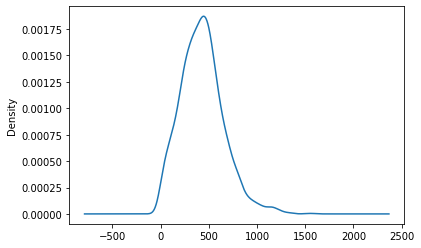

In [32]:
df_users_total['calls_duration'].plot(kind='density')

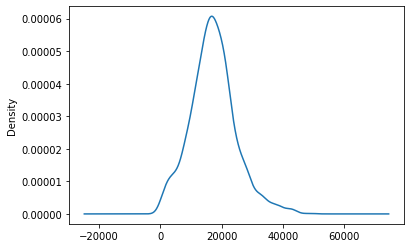

In [33]:
df_users_total['internet_mb_used'].plot(kind='density')

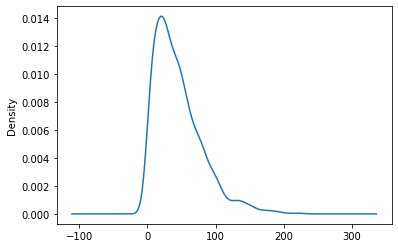

In [34]:
df_users_total['messages'].plot(kind='density')

Как видим серьезных выбросов нет, все данные имею распределение близкое к нормальному

Произведем рассчет дисперси, среднего и стандартного отклонения для каждого из тарифов

In [35]:
for k in ['smart','ultra']:
    print('Тариф:',k)
    for i in ('calls_duration','internet_mb_used','messages','total_revenue'):
        print(str(i))
        print('Дисперися:',np.var(df_users_total.loc[df_users_total['tariff']==k,i]))
        print('Стандартное отклонение:',np.sqrt(np.var(df_users_total.loc[df_users_total['tariff']==k,i])))
        print('Среднее значение:',df_users_total.loc[df_users_total['tariff']==k,i].mean(),'\n')

Тариф: smart
calls_duration
Дисперися: 32042.961646824417
Стандартное отклонение: 179.0054793765387
Среднее значение: 395.98920377867745 

internet_mb_used
Дисперися: 34344574.50652057
Стандартное отклонение: 5860.424430578435
Среднее значение: 16216.149012567324 

messages
Дисперися: 717.2208431102272
Стандартное отклонение: 26.78097912904282
Среднее значение: 38.71644120707596 

total_revenue
Дисперися: 614227.6879933281
Стандартное отклонение: 783.7267942295505
Среднее значение: 1210.4395338413267 

Тариф: ultra
calls_duration
Дисперися: 83908.04552626544
Стандартное отклонение: 289.6688549469298
Среднее значение: 515.3396424815983 

internet_mb_used
Дисперися: 98763155.47176856
Стандартное отклонение: 9937.965358752694
Среднее значение: 19668.994871794872 

messages
Дисперися: 2107.0055235156838
Стандартное отклонение: 45.90212983637779
Среднее значение: 61.161006289308176 

total_revenue
Дисперися: 131216.4100552042
Стандартное отклонение: 362.2380571602109
Среднее значение: 2061.

- Несмотря на то что среднее время звонков на тарифе 'smart' меньше на 25% по отношению к тарифу 'ultra', стандартное отклонение у первго меньше чем у второго на 40%.
Это может на сказать о том, что на более дорогом тарифе люди не выговаривают и половины минут пакета, в то вермя как на дешевом они стараются укладываться в лимит или выходить за него незначительно.
- Схожая ситуация и с интернетом. Разница использования трафика между тарифом 'smart' и 'ultra' составляет около 20%, в то время как отклонение 40%. Можно судить, что люди на тарифе 'ultra' стараются как раз использовать лимит интернета до предела, в то время как пользователи тарифа 'smart' часто его переступают.
- В плане сообщений пользователи тарифа 'smart' используют их ближе к лимиту, а более дорогого - примерно столько же как и на дешевом, но при этом лимит у них в 20 раз выше. Скорее всего СМС сообщениями люди пользуются в целом мало.

In [36]:
df_users_by_month=(df_users_total.groupby(['tariff','month'])
                   [['calls_duration','internet_mb_used','messages','total_revenue']].
                   agg(['sum','mean','count']))

In [37]:
df_users_by_month

calls_duration                   internet_mb_used                \
                        sum        mean count              sum          mean   
tariff month                                                                   
smart  1.0           6580.0  193.529412    34         289482.0   8514.176471   
       2.0          16438.0  283.413793    58         672656.0  11597.517241   
       3.0          28362.0  368.337662    77        1163058.0  15104.649351   
       4.0          38839.0  346.776786   112        1507817.0  13462.651786   
       5.0          51565.0  365.709220   141        2228598.0  15805.659574   
       6.0          61283.0  375.969325   163        2590405.0  15795.152439   
       7.0          77587.0  386.004975   201        3164469.0  15743.626866   
       8.0          93616.0  400.068376   234        3903634.0  16682.196581   
       9.0         105303.0  406.575290   259        4239065.0  16304.096154   
       10.0        118412.0  404.136519   293        4926731.0  16757.588435   
       11.0        129908.0  412.406349   315        5339197.0  16896.193038   
       12.0        152391.0  453.544643   336        6104468.0  18114.148368   
ultra  1.0           3648.0  405.333333     9         118272.0  13141.333333   
       2.0           6748.0  281.166667    24         282632.0  12846.909091   
       3.0          17130.0  462.972973    37         648835.0  17536.081081   
       4.0          23780.0  448.679245    53         925574.0  16828.618182   
       5.0          32308.0  504.812500    64        1297367.0  19657.075758   
       6.0          38090.0  470.246914    81        1589735.0  19153.433735   
       7.0          46929.0  533.284091    88        1865150.0  20723.888889   
       8.0          51618.0  501.145631   103        2094693.0  19761.254717   
       9.0          58605.0  527.972973   111        2208549.0  19373.236842   
       10.0         64859.0  549.652542   118        2465640.0  20210.163934   
       11.0         68522.0  531.178295   129        2651500.0  19936.090226   
       12.0         77851.0  580.977612   134        3029323.0  21951.615942   

                   messages                  total_revenue                     
             count      sum       mean count           sum         mean count  
tariff month                                                                   
smart  1.0      34    620.0  20.000000    31      23907.00   703.147059    34  
       2.0      58   1397.0  27.940000    50      45926.40   791.834483    58  
       3.0      77   2453.0  35.550725    69      84455.20  1096.820779    77  
       4.0     112   3443.0  35.864583    96     101234.00   903.875000   112  
       5.0     141   4762.0  39.032787   122     159518.60  1131.337589   141  
       6.0     164   5478.0  38.577465   142     185523.80  1131.242683   164  
       7.0     201   6784.0  38.988506   174     230373.00  1146.134328   201  
       8.0     234   7905.0  38.750000   204     290888.00  1237.821277   235  
       9.0     260   8746.0  39.219731   223     305368.80  1174.495385   260  
       10.0    294   9927.0  39.082677   254     377113.60  1282.699320   294  
       11.0    316  10768.0  39.881481   270     398018.60  1259.552532   316  
       12.0    337  12130.0  42.264808   287     497063.60  1474.966172   337  
ultra  1.0       9    304.0  43.428571     7      17550.00  1950.000000     9  
       2.0      22    527.0  32.937500    16      47357.25  1973.218750    24  
       3.0      37   1195.0  47.800000    25      74178.90  2004.835135    37  
       4.0      55   1736.0  44.512821    39     109785.90  1996.107273    55  
       5.0      66   2536.0  48.769231    52     137818.35  2056.990299    67  
       6.0      83   3505.0  52.313433    67     170814.00  2033.500000    84  
       7.0      90   4536.0  62.136986    73     192151.65  2111.556593    91  
       8.0     106   5183.0  58.897727    88     221841.75  2073.287383   107  
       9.0  

Мы видим плавное увеличение числа пользователей в течение года. Пользователей тарифа 'smart' в среднем в 2 раза больше, чем 'ultra'.
- Соответственно, люди подключенные к 'smart' тратят в два раза больше минут звонков,чем пользователи 'ultra', хотя разница в среднем показателе отличается в пользу второго всего на 20%. При этом если люди с тарфом 'smart' укладываются в свой пакет или выходят за него не значительно, то  пользователи 'ultra' недобирают и половины пакета, а по итогу разговаривают чуть больше, чем пользователи более дешевого тарифа.
- Если же рассмотреть потребление интернет трафика, то видим схожую картину. Общая сумма потребления трафика между пользователями тарифов отличается от месяца к месяцу примерно в 2 раза, но среднее потребление трафика с течением года на тарифе 'smart' вырастает в 2 раза и выходит за лимит пакета, что заставляет пользователь вносить дополнительную плату, а на тарифе 'ultra' мы видим, что потребление трафика возрастает за год на 50% и при этом пользователи тратят всего лишь 2/3 всего пакета.
- СМС сообщения в обоих пакетах пользуются низкой популярностью по сравнению с звонками. В среднем пользователи укладываются в лимит пакета. Но если и выходят за него, то доля выручки от СМС будет незначительна.

На основании всего вышесказанного можно сделать вывод, что тариф 'ultra' является избыточным для пользователей и им редко приходится платить сверх тарифа, но их потребление мало отличается от пользователей тарифа 'smart'.
В то время как для пользователей тарифа 'smart' лимита минут в среднем достаточно, но потребление трафика интернета выходит за лимит, что заставляет их тратить дополнительные средства для обеспечения своих потребностей.
Номинально мы видим, что средние траты пользователей тарифа 'ultra' выше, чем пользователей 'smart', но доход сверх тарифа доходит до 20%, а в случае тарифа 'smart' видим обратную картину. Номинальная стоимость ниже, но доход сверх тарифа доходит до практически 150% к концу года.

### Шаг 4. Проверьте гипотезы

###### средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Применим гипотезу о равенстве двух генеральных совокупностей. За нулевую гипотезу примем случай равенства средней выручки тарифов.

H0 : total_revenue('ultra').mean == total_revenue('smart').mean 
___
H1 : total_revenue('ultra').mean != total_revenue('smart').mean 

In [38]:
total_revenue_ultra=df_users_total.query('tariff=="ultra"')['total_revenue'].dropna()
total_revenue_ultra
total_revenue_ultra.mean()

2061.835519677094

In [39]:
total_revenue_smart=df_users_total.query('tariff=="smart"')['total_revenue'].dropna()
total_revenue_smart
total_revenue_smart.mean()

1210.4395338413267

In [40]:
alpha=0.05

In [41]:
result_test1=st.ttest_ind(total_revenue_ultra,total_revenue_smart, equal_var=False)

In [42]:
print(result_test1.pvalue)

1.652185663011003e-309


In [43]:
if result_test1.pvalue > alpha:
    print('Нулевую гипотезу не получается отвергнуть')
else:
    print('Нулева гипотеза отвергнута')

Нулева гипотеза отвергнута


Как видим наша гипотезу отвергнута, мы с вероятностью близкой к 0 могли бы получить такие значения

###### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Также применим гипотезу о равенстве двух генеральных совокупностей. За нулевую гипотезу примем случай равенства средней выручки пользователей из Москвы и других регионов.

H0 : total_revenue_moscow.mean()==total_revenue_notmoscow.mean()
_____
H1 : total_revenue_moscow.mean()!=total_revenue_notmoscow.mean()

In [44]:
total_revenue_moscow=df_users_total.query('city=="Москва"')['total_revenue'].dropna()
total_revenue_moscow
total_revenue_moscow.mean()

1493.9837152209493

In [45]:
total_revenue_notmoscow=df_users_total.query('city!="Москва"')['total_revenue'].dropna()
total_revenue_notmoscow
total_revenue_notmoscow.mean()

1467.2330716200688

In [46]:
result_test2=st.ttest_ind(total_revenue_moscow,total_revenue_notmoscow, equal_var=False)

In [47]:
alpha=0.05

In [48]:
print(result_test2.pvalue)

0.4309304217375167


In [49]:
if result_test2.pvalue > alpha:
    print('Нулевую гипотезу не получается отвергнуть')
else:
    print('Нулева гипотеза отвергнута')

Нулевую гипотезу не получается отвергнуть


Как видим, хоть наши средние выручки и не одинаковые, но с вероятностью 47% процентов мы могли получить такие значения случайной величины или больше. Эта вероятность достаточна, чтобы не отвергать гипотезу

## Вывод:


* Мы прочитали таблицы, объединили их, произвели замену пропусков где это возможно, посчитали параметры выручки для каждого пользователя по месяцам, проанализировали гистограммы, посчитали дисперсию и стандартное отклонение для каждого тарифа, построили сводную таблицу по тратам трафика по каждому направлению(звонки, интернет, СМС) и выручкой средней и общей по месяцам.
* Проанализировали эти данные, сделали первые предположения о поведении клиентов, их тратах сверх тарифа.  
Пользователи более дорогого тарифа 'ultra' меньше тратят денег сверх тарифа, при этом недоиспользуют лимиты трафика, а пользователи более дешевого тарифа в случае звонков используют лимит тарифа по максимуму и редко переплачивают по этому параметру, в то время как они часто докупают дополнительный интернет, что и составляет большую часть их трат сверх пакета. 
В итоге получаем, что стоимость тарифа 'smart' выростает практически в 2.5 раза по сравнению с базовой стоимостью.
* Статистически проверили две гипотезы:
    - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
    - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов  
По результатам проверки мы отвергли первух гипотезу и не отвергли вторую.
* Однозначно оценить тарифы не получается, с одной стороны у тарифа 'ultra' выше средяя выручка от пользователя, но в целом пользователей меньше и суммарный доход ниже чем от тарифа 'smart'. Можно предположить, что перспективнее является более дешевый тариф за счет большего кол-ва пользователей и возможности их дополнительно покупать трафик, но данная ситуация нестабильна и если конкуренты предложат более выгодный тариф с большим лимитом интернета за примелемую сумму, то они могут быстро перейти, т.к. их основные траты это интернет.   
Можно предложить развивать тариф 'ultra', но его цена высокая и лимиты в тарифе избыточны.  
Можно скорректировать лимиты и снизить цену, уменьшив минуты и трафик интернета. В таком случае мы можем получить сбалансированный тариф. 